In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# Task 1: Preprocess Data

In [2]:
# download and load datasets into Pandas Dataframe
hospital_data = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv')
daily_symptom_data = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_daily_symptoms_dataset.csv')

## Convert daily symptom data to weekly symptom data

In [3]:
# drop unnecessary columns
daily_symptom_data.drop(['country_region', 'country_region_code', 'sub_region_1', 'sub_region_1_code', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace=True)

# group symptom data by region
d = dict(tuple(daily_symptom_data.groupby('open_covid_region_code')))

summed_daily_data = []

for region, region_data in d.items():

    # get earliest start of week date
    min_date_str = region_data['date'].min()
    min_date = date(*map(int, min_date_str.split('-')))
    start_week = min_date + timedelta(days=(7 - min_date.weekday()) % 7)
    end_week = start_week + timedelta(days=7)

    # convert date strings to actual date type
    region_data['date'] = region_data['date'].map(lambda x: date(*map(int, x.split('-'))))

    # select data from week
    weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]
    weekly_data = weekly_data[[s for s in daily_symptom_data.columns.values if s.startswith('symptom:')]]

    # sum daily symptom data for each full week in the region's data set
    while weekly_data.shape[0] == 7:
        col_vals = [region, start_week]
        col_vals.extend(weekly_data.mean(skipna=False).values)
        summed_daily_data.append(col_vals)

        start_week = end_week
        end_week = start_week + timedelta(days=7)
        weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]
        weekly_data = weekly_data[[s for s in daily_symptom_data.columns.values if s.startswith('symptom:')]]

symptoms_data = pd.DataFrame(data=summed_daily_data, columns=daily_symptom_data.columns.values)

## Clean symptom data

In [4]:
# Allow symptom data to have some missing data points
region_sparseness_thresh = 0.9

symptom_names = [s for s in symptoms_data.columns.values if s.startswith('symptom:')]
num_weeks = symptoms_data['open_covid_region_code'].value_counts()[0]

# Split by regions
symptoms_data.dropna(axis='columns', how='all', inplace=True)

region_symptoms = dict(tuple(symptoms_data.groupby('open_covid_region_code')))

# Drop symptoms from regions that are incomplete
for region, region_data in region_symptoms.items():
    region_data.dropna(axis='columns', how='all', inplace=True)
    region_data = region_data.loc[: , (region_data.count() >= num_weeks*region_sparseness_thresh)]
    region_symptoms[region] = region_data.loc[: , (region_data.count() >= num_weeks*region_sparseness_thresh)]

filtered_symptom_data = pd.concat(region_symptoms, ignore_index=True)

## Interpolate symptom data

In [5]:
interpolated_region_symptoms = dict()
for region, region_data in region_symptoms.items():
    for s in region_data.columns.values:
        if s.startswith('symptom:'):
            region_data[s] = region_data[s].interpolate()

    interpolated_region_symptoms[region] = region_data

interpolated_symptom_data = pd.concat(interpolated_region_symptoms, ignore_index=True)

## Clean hospital data

In [6]:
# drop non USA regions
hospital_data = hospital_data[hospital_data['open_covid_region_code'].str.contains('US-')]

# drop irrelavent data
hospital_data = hospital_data.filter(['open_covid_region_code', 'date', 'hospitalized_new'])

# aggregate daily to weekly
d = dict(tuple(hospital_data.groupby('open_covid_region_code')))

aggregated_data = []
min_start_date = date(*map(int, hospital_data['date'].min().split('-')))

for region, region_data in d.items():

    # skip if total hospitalization data is zero
    if region_data['hospitalized_new'].sum() == 0:
        continue

    # get earliest start of week date
    min_date_str = region_data['date'].min()
    min_date = date(*map(int, min_date_str.split('-')))
    start_week = min_date + timedelta(days=(7 - min_date.weekday()) % 7)
    end_week = start_week + timedelta(days=7)

    # Set common start date
    min_start_date = max(min_start_date, start_week)

    # convert date strings to actual date type
    region_data['date'] = region_data['date'].map(lambda x: date(*map(int, x.split('-'))))

    # select data from week
    weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]

    # sum hospital for each full week in the region's data set
    while weekly_data.shape[0] == 7:
        aggregated_data.append([region, start_week, weekly_data['hospitalized_new'].sum()])

        start_week = end_week
        end_week = start_week + timedelta(days=7)
        weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]

filtered_hospital_data = pd.DataFrame(data=aggregated_data, columns=['open_covid_region_code', 'date', 'hospitalized_new'])

# Drop all rows before common start date
filtered_hospital_data = filtered_hospital_data[filtered_hospital_data['date'] >= min_start_date]

## Join symptom and hospital data

In [7]:
merged_data = pd.merge(interpolated_symptom_data, filtered_hospital_data, on=['open_covid_region_code', 'date'])
merged_data.dropna(axis='columns', how='any', inplace=True)

# Drop symptoms with missing region data
merged_data.dropna(axis='columns', how='any', inplace=True)

# interpolated_merged_data.to_csv('../data/interpolated_merged_data.csv')

# Task 2: Data Visualization

In [8]:
import matplotlib.pyplot as plt

chosen_symptoms = ['symptom:Cough', 'symptom:Common cold' , 'symptom:Fever']
symptom_names = [s for s in merged_data.columns.values if s.startswith('symptom:')]
region_names = merged_data['open_covid_region_code'].unique()

by_state = merged_data.groupby('open_covid_region_code')

date_data = by_state.get_group(region_names[0]).sort_values(by=['date'])['date']

## Popularity of symptoms

In [15]:
from ipywidgets import widgets, interactive

hospitalization = widgets.Dropdown(
    options=[True, False],
    value=False,
    description='Show hospitalizations: ',
)

symptom = widgets.Dropdown(
    options=symptom_names,
    value='symptom:Fever',
    description='Symptoms: ',
)

region = widgets.Dropdown(
    options=['All of USA'] + list(region_names),
    value='All of USA',
    description='Regions: ',
)

def plot_graph(region, symptom, hospitalization):
    regions = region_names
    alpha = 0.2

    fig, symptom_plt = plt.subplots()
    hosp_plt = symptom_plt.twinx()

    # Aggregate hospital data across regions
    hospital_data = merged_data.groupby('date').sum().filter(['hospitalized_new'])

    # Adjust values if selecting individual region
    if region != 'All of USA':
        regions = [region]
        alpha = 0.9
        hospital_data = merged_data.loc[merged_data['open_covid_region_code'] == region].groupby('date').sum().filter(['hospitalized_new'])

    hosp_plt.set_ylabel('New Hospitalizations', color='tab:blue')
    hosp_plt.tick_params(axis='y', labelcolor='tab:blue')

    # Show hospitalization data only if selected
    if hospitalization:
        hosp_plt.plot(hospital_data.index.values, hospital_data['hospitalized_new'].values, color='tab:blue', alpha=0.8)

    for index, region_name in enumerate(regions):

        temp = by_state.get_group(region_name).sort_values(by=['date'])[symptom]

        # calculate median and divide the values in array by median
        temp = np.true_divide(temp, np.median(temp))

        symptom_plt.plot(date_data, temp, color='tab:red', alpha=alpha)

    symptom_plt.tick_params(axis='y', labelcolor='tab:red')
    symptom_plt.set_ylabel('Relative Search Frequency', color='tab:red')
    symptom_plt.set_xlabel('Date')
    fig.tight_layout()
    plt.title(symptom[len('symptom:'):] + " : " + region)
    plt.xticks(rotation=90)
    plt.show()

interactive(plot_graph, region=region, symptom=symptom, hospitalization=hospitalization)

interactive(children=(Dropdown(description=&#39;Regions: &#39;, options=(&#39;All of USA&#39;, &#39;US-AL&#39;, &#39;US-AR&#39;, &#39;US-AZ&#39;, &#39;US-CO&#39;, &#39;US-CT&#39;, &#39;US-FL&#39;, &#39;US-GA&#39;, &#39;US-HI&#39;, &#39;US-ID&#39;, &#39;US-IN&#39;, &#39;US-KS&#39;, &#39;US-KY&#39;, &#39;US-MA&#39;, &#39;US-MD&#39;, &#39;US-ME&#39;, &#39;US-MN&#39;, &#39;US-MS&#39;, &#39;US-MT&#39;, &#39;US-ND&#39;, &#39;US-NE&#39;, &#39;US-NH&#39;, &#39;US-NJ&#39;, &#39;US-NM&#39;, &#39;US-NY&#39;, &#39;US-OH&#39;, &#39;US-OK&#39;, &#39;US-OR&#39;, &#39;US-RI&#39;, &#39;US-SC&#39;, &#39;US-SD&#39;, &#39;US-TN&#39;, &#39;US-UT&#39;, &#39;US-VA&#39;, &#39;US-WA&#39;, &#39;US-WI&#39;, &#39;US-WY&#39;), value=&#39;All of USA&#39;), Dropdown(description=&#39;Symptoms: &#39;, index=33, options=(&#39;symptom:Abdominal obesity&#39;, &#39;symptom:Abdominal pain&#39;, &#39;symptom:Acne&#39;, &#39;symptom:Alcoholism&#39;, &#39;symptom:Allergy&#39;, &#39;symptom:Anemia&#39;, &#39;symptom:Anxiety&#39;, &#39;symptom:Arthritis&#39;, &#39;symptom:Asthma&#39;, &#39;symptom:Attention deficit hyperactivity disorder&#39;, &#39;symptom:Autoimmune disease&#39;, &#39;symptom:Back pain&#39;, &#39;symptom:Bleeding&#39;, &#39;symptom:Bloating&#39;, &#39;symptom:Bone fracture&#39;, &#39;symptom:Bruise&#39;, &#39;symptom:Burn&#39;, &#39;symptom:Candidiasis&#39;, &#39;symptom:Chest pain&#39;, &#39;symptom:Common cold&#39;, &#39;symptom:Constipation&#39;, &#39;symptom:Cough&#39;, &#39;symptom:Cramp&#39;, &#39;symptom:Dementia&#39;, &#39;symptom:Depression&#39;, &#39;symptom:Dermatitis&#39;, &#39;symptom:Diabetes&#39;, &#39;symptom:Diarrhea&#39;, &#39;symptom:Dizziness&#39;, &#39;symptom:Dysmenorrhea&#39;, &#39;symptom:Epilepsy&#39;, &#39;symptom:Erectile dysfunction&#39;, &#39;symptom:Fatigue&#39;, &#39;symptom:Fever&#39;, &#39;symptom:Flatulence&#39;, &#39;symptom:Gastroesophageal reflux disease&#39;, &#39;symptom:Gout&#39;, &#39;symptom:Hair loss&#39;, &#39;symptom:Hay fever&#39;, &#39;symptom:Headache&#39;, &#39;symptom:Heart arrhythmia&#39;, &#39;symptom:Heartburn&#39;, &#39;symptom:Hemorrhoids&#39;, &#39;symptom:Hives&#39;, &#39;symptom:Hypertension&#39;, &#39;symptom:Hypotension&#39;, &#39;symptom:Hypothyroidism&#39;, &#39;symptom:Implantation bleeding&#39;, &#39;symptom:Indigestion&#39;, &#39;symptom:Infection&#39;, &#39;symptom:Inflammation&#39;, &#39;symptom:Insomnia&#39;, &#39;symptom:Iron deficiency&#39;, &#39;symptom:Itch&#39;, &#39;symptom:Kidney stone&#39;, &#39;symptom:Knee Pain&#39;, &#39;symptom:Low back pain&#39;, &#39;symptom:Major depressive disorder&#39;, &#39;symptom:Migraine&#39;, &#39;symptom:Myocardial infarction&#39;, &#39;symptom:Nausea&#39;, &#39;symptom:Neck pain&#39;, &#39;symptom:Obesity&#39;, &#39;symptom:Otitis&#39;, &#39;symptom:Pain&#39;, &#39;symptom:Panic attack&#39;, &#39;symptom:Paresthesia&#39;, &#39;symptom:Perspiration&#39;, &#39;symptom:Psychosis&#39;, &#39;symptom:Scar&#39;, &#39;symptom:Sinusitis&#39;, &#39;symptom:Skin condition&#39;, &#39;symptom:Skin rash&#39;, &#39;symptom:Skin ulcer&#39;, &#39;symptom:Sleep apnea&#39;, &#39;symptom:Sleep disorder&#39;, &#39;symptom:Sore throat&#39;, &#39;symptom:Stroke&#39;, &#39;symptom:Swelling&#39;, &#39;symptom:Type 2 diabetes&#39;, &#39;symptom:Urinary tract infection&#39;, &#39;symptom:Vaginal discharge&#39;, &#39;symptom:Vertigo&#39;, &#39;symptom:Vomiting&#39;, &#39;symptom:Wart&#39;, &#39;symptom:Weight gain&#39;, &#39;symptom:Xeroderma&#39;), value=&#39;symptom:Fever&#39;), Dropdown(description=&#39;Show hospitalizations: &#39;, index=1, options=(True, False), value=False), Output()), _dom_classes=(&#39;widget-interact&#39;,))

## PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#PCA
#get only columns with symptoms
#merged_data = pd.read_csv('../data/interpolated_merged_data_scaled.csv')
X=merged_data[merged_data.columns[3:len(symptom_names)+3]]
# print(X)
#Figure out how many components (kinda useless)
pca2 = PCA()
pca2.fit_transform(StandardScaler().fit_transform(X))
num_pc_components = len(pca2.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca2.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")

plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")
plt.show()


pca = PCA(n_components=20)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(X))# Plot the explained variances
#principalComponents = pca.fit(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
plt.show()

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

#PCA graph
markersize=4
pca = PCA(n_components=3)
#pca.fit(X)
#X_reduced = pca.transform(X)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize)
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

#PCA graph with standardized data
markersize=4
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(StandardScaler().fit_transform(X))
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize)
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

NameError: name &#39;StandardScaler&#39; is not defined

## Clustering

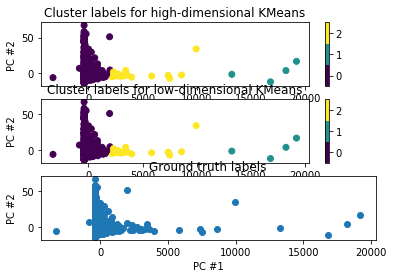

In [11]:
from sklearn.cluster import KMeans

kmeans_high = KMeans(n_clusters=3, random_state=0)
kmeans_high.fit(X)
y_pred_high = kmeans_high.predict(X)

kmeans_low = KMeans(n_clusters=3, random_state=0)
kmeans_low.fit(X_reduced)
y_pred_low = kmeans_low.predict(X_reduced)

# Plot 3 scatter plots -- two for high and low dimensional clustering results and one indicating the ground truth labels

plt.subplot(3,1,1)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_pred_high, cmap=plt.cm.get_cmap('viridis',3))
plt.colorbar(ticks=[0,1,2])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for high-dimensional KMeans")

plt.subplot(3,1,2)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_pred_low, cmap=plt.cm.get_cmap('viridis',3))
plt.colorbar(ticks=[0,1,2])
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for low-dimensional KMeans")

plt.subplot(3,1,3)
#plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('viridis',3))
plt.scatter(X_reduced[:,0], X_reduced[:,1], cmap=plt.cm.get_cmap('viridis',3))
#plt.colorbar(ticks=[0,1,2], format=formatter)
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Ground truth labels")
plt.show()

# Task 3: Supervised Learning

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Part 1

In [13]:
#split into training and validation sets based on region (80% train 20% validate)
regions = merged_data.groupby(merged_data['open_covid_region_code']).aggregate('count')
region_names = list(regions.index) #list of all the region names
slice = (int) (len(region_names) / 5)

region_groups = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

for i in range(5):
    for j in range(slice):
        region_groups[i] = region_groups[i].append(merged_data[merged_data['open_covid_region_code'] == region_names[i * slice + j]])

if (slice * 5 < len(region_names)): #number of regions doesn't divide equally in 5 parts
    region_groups[0] = region_groups[0].append(merged_data[merged_data['open_covid_region_code'] == region_names[5 * slice]])
if (slice * 5 + 1 < len(region_names)):
    region_groups[1] = region_groups[1].append(merged_data[merged_data['open_covid_region_code'] == region_names[5 * slice + 1]])
if (slice * 5 + 2 < len(region_names)):
    region_groups[2] = region_groups[2].append(merged_data[merged_data['open_covid_region_code'] == region_names[5 * slice + 2]])
if (slice * 5 + 3 < len(region_names)):
    region_groups[3] = region_groups[3].append(merged_data[merged_data['open_covid_region_code'] == region_names[5 * slice + 3]])


#split into training and validation sets based on time (data after a timestamp for validate, before for train)
dates = merged_data.groupby(merged_data['date']).aggregate('count')
dates_span = list(dates.index) #list of all dates
slice = dates_span.index(date(2020,8,10)) + 1 #keep dates after 2020-08-10

time_training = pd.DataFrame()
time_validation = pd.DataFrame()

for a in range(slice):
    time_training = time_training.append(merged_data[merged_data['date'] == dates_span[a]])

for b in range(len(dates_span) - slice):
    time_validation = time_validation.append(merged_data[merged_data['date'] == dates_span[a + 1 + b]])
    #print(time_validation.iloc[:,6])

## Part 2

In [14]:
#predict hospitalization based on symptom search

#KNN regression performance with regions (5-fold cross validation)
region_training = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()] #5-fold cross validation
region_validation = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

for c in range(5):
    region_validation[c] = region_groups[c]
    for d in range(5):
        if (d != c):
            region_training[c] = region_training[c].append(region_groups[d])

symptom_names = [s for s in merged_data.columns.values if s.startswith('symptom:')]

start = merged_data.columns.get_loc(symptom_names[0])
end = merged_data.columns.get_loc(symptom_names[-1])

#assuming all symptom columns are one next to another in merged_data
#SHOULD WE PERFORM SCALING?

k = [1, 3, 5, 10, 15, 20]

region_k_array_results = np.empty((len(k), 3)) #k, mean of costs for 5-fold, variance of costs for 5-fold

for m in range(len(k)): #trying different K's
    five_fold_cost = [0, 0, 0, 0, 0]

    for n in range(5):
        X_train = region_training[n].iloc[:, start:(end + 1)].values #symptoms
        y_train = region_training[n].iloc[:, -1].values #new hospitalizations
        X_valid = region_validation[n].iloc[:, start:(end + 1)].values
        y_valid = region_validation[n].iloc[:, -1].values
        #print(region_training[n])
        #print("NEXT")
        #print(X_train)

        regressor = KNeighborsRegressor(n_neighbors=k[m])
        regressor.fit(X_train, y_train)
        y_predicted = regressor.predict(X_valid)
        #print(X_valid.shape)
        #print(y_predicted.shape)
        #print(X_valid)
        #print(y_predicted)
        #print("Y VALID")
        #print(y_valid)
        cost = 0
        
        for u in (range(len(y_predicted))):
            error = (y_predicted[u] - y_valid[u])**2
            #print(error)
            cost = cost + error

        cost = cost/(len(y_predicted))
        #print(cost)
        five_fold_cost[n] = cost
    
    #calculate the mean and variance for 5-fold
    mean = (five_fold_cost[0] + five_fold_cost[1] + five_fold_cost[2] + five_fold_cost[3] + five_fold_cost[4])/5
    variance = np.var(five_fold_cost)
    
    region_k_array_results[m][0] = k[m]
    region_k_array_results[m][1] = mean
    region_k_array_results[m][2] = variance

#the best KNN with regions
region_best_mean = float("inf")
region_best_index = 0

for t in range(len(region_k_array_results)):
    if (region_k_array_results[t][1] < region_best_mean):
        region_best_mean = region_k_array_results[t][1]
        region_best_index = t
#IN THE NOTES IT SAYS TO CHOOSE THE SIMPLEST MODEL WITHIN 1 STANDARD DEVIATION BUT IDK WHAT HE MEANS BY THT


#KNN regression performance with date
time_k_array_results = np.empty((len(k), 2)) #k, cost

for m in range(len(k)): #trying different K's
    
    X_train = time_training.iloc[:, start:(end + 1)].values #symptoms
    y_train = time_training.iloc[:, -1].values #new hospitalizations
    X_valid = time_validation.iloc[:, start:(end + 1)].values
    y_valid = time_validation.iloc[:, -1].values
    #print(region_training[n])
    #print("NEXT")
    #print(X_train)

    regressor = KNeighborsRegressor(n_neighbors=k[m])
    regressor.fit(X_train, y_train)
    y_predicted = regressor.predict(X_valid)
    #print(X_valid.shape)
    #print(y_predicted.shape)
    #print(X_valid)
    #print(y_predicted)
    #print("Y VALID")
    #print(y_valid)
    cost = 0
        
    for u in (range(len(y_predicted))):
        error = (y_predicted[u] - y_valid[u])**2
        #print(error)
        cost = cost + error

    cost = cost/(len(y_predicted))
    #print(cost)
        
    time_k_array_results[m][0] = k[m]
    time_k_array_results[m][1] = cost

#the best KNN with dates
time_best_cost = float("inf")
time_best_index = 0

for t in range(len(time_k_array_results)):
    if (time_k_array_results[t][1] < time_best_cost):
        time_best_cost = time_k_array_results[t][1]
        time_best_index = t

#print(time_k_array_results)
#print(time_best_index)

#decision tree regression performance with regions

five_fold_cost = [0, 0, 0, 0, 0]

for n in range(5):
     X_train = region_training[n].iloc[:, start:(end + 1)].values #symptoms
     y_train = region_training[n].iloc[:, -1].values #new hospitalizations
     X_valid = region_validation[n].iloc[:, start:(end + 1)].values
     y_valid = region_validation[n].iloc[:, -1].values

     regressor = DecisionTreeRegressor(random_state=0)
     regressor.fit(X_train, y_train)
     y_predicted = regressor.predict(X_valid)

     cost = 0
     for u in (range(len(y_predicted))):
        error = (y_predicted[u] - y_valid[u])**2
        #print(error)
        cost = cost + error

     cost = cost/(len(y_predicted))
     #print(cost)
     five_fold_cost[n] = cost

region_decision_tree_avg_cost = (five_fold_cost[0] + five_fold_cost[1] + five_fold_cost[2] + five_fold_cost[3] + five_fold_cost[4])/5  
#print(region_decision_tree_avg_cost)


#decision tree regression performance with date

X_train = time_training.iloc[:, start:(end + 1)].values #symptoms
y_train = time_training.iloc[:, -1].values #new hospitalizations
X_valid = time_validation.iloc[:, start:(end + 1)].values
y_valid = time_validation.iloc[:, -1].values

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
y_predicted = regressor.predict(X_valid)

cost = 0
for u in (range(len(y_predicted))):
    error = (y_predicted[u] - y_valid[u])**2
    #print(error)
    cost = cost + error

cost = cost/(len(y_predicted))
print(region_k_array_results)
print(time_k_array_results)
print("KNN with regions average cost: " + str(region_best_mean) + " with optimal k = " + str(region_k_array_results[region_best_index][0]))
print("KNN with dates cost: " + str(time_best_cost) + " with optimal k = " + str(time_k_array_results[time_best_index][0]))
print("decision tree with region average cost: " + str(region_decision_tree_avg_cost))
print("decision tree with dates cost: " + str(cost))

[[  1.00000000e+00   2.36450806e+06   6.38689462e+12]
 [  3.00000000e+00   1.77196368e+06   6.46086181e+12]
 [  5.00000000e+00   1.77263817e+06   6.54422126e+12]
 [  1.00000000e+01   1.74885278e+06   6.85869144e+12]
 [  1.50000000e+01   1.74235158e+06   6.97219036e+12]
 [  2.00000000e+01   1.74295989e+06   7.03539097e+12]]
[[  1.00000000e+00   2.45596522e+06]
 [  3.00000000e+00   5.70585332e+05]
 [  5.00000000e+00   3.11844157e+05]
 [  1.00000000e+01   1.53948568e+05]
 [  1.50000000e+01   1.04629670e+05]
 [  2.00000000e+01   9.66923890e+04]]
KNN with regions average cost: 1742351.58459 with optimal k = 15.0
KNN with dates cost: 96692.3890476 with optimal k = 20.0
decision tree with region average cost: 2616643.23091
decision tree with dates cost: 1118651.01984
